# Prototype code to perform peak fits and scaling fits using lmfit

## Index:
* [functions](# func)
* [fit](# fit)

### Goals:
- Keep a simple prototype for curve fitting using lmfit.
- Keep minimal dependence i.e. no gvar.
- Keep it general. So, avoid modularizing input data.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import glob
import os
from lmfit import Model, Parameters
from lmfit.models import LinearModel, ExponentialModel, PowerLawModel
# Graphics
%matplotlib notebook
import matplotlib.pyplot as plt
# plt.style.use('ggplot')

import itertools

# Code for neat formatting.
from IPython.display import display, HTML, Markdown
def printmd(string):
    display(Markdown(string))




<a id = ' func'></a>
### The functions used in fit and plot

In [2]:
# Function for fitting

def f_choose_fit(ft,param,verbose=False):  
    if ft==1: # defining powerlaw fit
        par_names=['a1','p1']
        fit_name='Powerlaw'
        def func(x,a1,p1):
            '''
            f(x)= a1 x^(p1)
            '''
            ans= a1 * x**(p1)
            return ans

    elif ft==2: # defining 2-powerlaw fit
        par_names=['a1','p1','a2','p2']
        fit_name='Two-powerlaw'
        def func(x,a1,p1,a2,p2):
            '''
            f(x)= a1 x^(p1) + a2 x^(p2)
            '''
            ans= a1 * x**(p1)+a2 * x**(p2)
            return ans  

    elif ft==3: # defining constant + power-law fit
        par_names=['a1','p1','a2']
        fit_name='Const+power'
        def func(x,a1,p1,a2):
            '''
            f(x)= a1 L^(p1) + a2
            '''
            ans= a1 * x**(p1) + a2
            return ans      
 
    elif ft==4: # defining exponential fit
        par_names=['a1','p1']
        fit_name='Exponential'

        def func(x,a1,p1):
            '''
            f(x)= a1 e^(p1*x)
            '''
            ans= a1 * np.exp(p1*x)
            return ans  

    elif ft==5: # defining constant + exponential fit
        par_names=['a1','p1','a2']
        fit_name='Const+exp'

        def func(x,a1,p1,a2):
            '''
            f(x)= a1 e^(p1*x) + a2
            '''
            ans= a1 * np.exp(p1*x) + a2
            return ans   

    elif ft==6: # defining Peakfit
        par_names=['chi_p','Up','a1','a2','a3']
        fit_name='Peak-fit'
       
        def func(x,chi_p,Up,a1,a2,a3):
            '''
            f(x)=chi_p + a1 (x-U_p)^2 + a2 (x-U_p)^3  + a3 (x-U_p)^4
            '''
            ans=chi_p + a1 *(x-Up)**2 + a2 *(x-Up)**3  + a3 *(x-Up)**4
            return ans
        
    elif ft==7: # defining inverse log
        par_names=['a1','a2']
        fit_name='Inv log'
        def func(x,a1,a2):
            '''
            f(x)= a1/(a2+np.log(x))
            '''
            ans= a1/(a2+ np.log(x))
            return ans
        
    elif ft==8: # defining inverse log
        par_names=['a1','a2']
        fit_name='two power log'
        def func(x,a1,a2):
            '''
            f(x)= a1/(np.log(x)+a2/(np.log(x)**2
            '''
            ans= a1/(np.log(x))+a2/((np.log(x))**2)

            return ans
    else:
#         print "Invalid fit number"
        raise SystemError

    
    dict1={key : value  for (key,value) in zip(par_names,param)}
    if verbose: print func.__doc__.strip('\n').strip('  ') # Prints the functional form of fit function.
    return func,dict1


In [3]:
# Functions for extracting and fitting data.

def f_fit(func,xdata,ydata,yerr,param,dict1):
    '''
    Performs the fits using the function 'func' and the lmfit module
    '''
    gmod=Model(func)
#     help(func)
    fx_list=[] # this stores the names of the parameters that are fixed
    for keys in dict1:
#         print type(keys),type(dict1[keys])
        if dict1[keys][0]=='f':
            dict1[keys]=np.float64(dict1[keys][1:])
            fx_list.append(keys)
        else :
            dict1[keys]=np.float64(dict1[keys])
    
    pars=gmod.make_params(**dict1)
    
#     print dict1,'\n'
    if fx_list: # checking if the list is empty
        for vv in fx_list: pars[vv].vary=False # Fix those parameters         
            
    result=gmod.fit(ydata,params=pars,x=xdata,weights=1.0/yerr)

    return result


def f_plot(func,xdata,ydata,yerr,result,title='',ylabel='y',xlabel='x',curve_label=''):
    
    plt.figure()

    setsize=100 # This is the number of data points used for the continuous curve
    curvex=np.linspace(min(xdata),max(xdata),setsize)
    curvey=func(curvex,**result.best_values) # result.best_values holds the best fit results in a dict. 

    plt.xlabel(xlabel,size=20)
    plt.ylabel(ylabel,size=20,rotation='horizontal')  
    plt.title(title)

    plt.xlim([min(xdata)*0.9,max(xdata)*1.1])
    plt.errorbar(xdata,ydata,yerr,linestyle='None',color='r',marker='o',markersize=5)
    plt.plot(curvex,curvey,linestyle='-',label=curve_label)
    plt.legend(loc='best',prop={'size':15},numpoints=1)
#     plt.plot(xdata, result.best_fit, 'r--')



<a id = ' fit'></a>
### Peak fit 



In [4]:
# Simple peak fit of sus1
if __name__ == '__main__': 
    # Get data from file.
    data_dir='test_data/'
    df2=pd.read_csv(data_dir+'SUS_1',sep='\t',names=['U','L','sus','dsus']).reset_index().drop('index',1)
    # df2

    df3=df2[df2.L==32][['U','sus','dsus']]
    df4=df3[(df3.U>0.35) & (df3.U<0.44)]
    # df3
    dta=df4.as_matrix().astype(np.float64)[1:]
    xdata,ydata,yerr=dta[:,0],dta[:,1],dta[:,2]
    print xdata,ydata,yerr


[ 0.37  0.38  0.39  0.4   0.41  0.42  0.43] [ 3.23190025  3.31273137  3.35112978  3.37401413  3.34427884  3.29707684
  3.22748678] [ 0.00500566  0.00469461  0.0043059   0.00397634  0.00369756  0.00354921
  0.00340632]


f(x)=chi_p + a1 (x-U_p)^2 + a2 (x-U_p)^3  + a3 (x-U_p)^4

[[Model]]
    Model(func)
[[Fit Statistics]]
    # function evals   = 223
    # data points      = 7
    # variables        = 5
    chi-square         = 4.300
    reduced chi-square = 2.150
    Akaike info crit   = 6.589
    Bayesian info crit = 6.318
[[Variables]]
    chi_p:   2.88105520 +/- 0.723064 (25.10%) (init= 1)
    Up:      0.32645906 +/- 0.054432 (16.67%) (init= 0.4)
    a1:      390.038529 +/- 51.65704 (13.24%) (init= 1)
    a2:     -5602.95890 +/- 3.88e+03 (69.26%) (init= 1)
    a3:      20746.5469 +/- 2.81e+04 (135.21%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
    C(chi_p, Up)                 =  0.998 
    C(a2, a3)                    = -0.997 
    C(Up, a3)                    =  0.988 
    C(chi_p, a3)                 =  0.978 
    C(Up, a2)                    = -0.973 
    C(chi_p, a2)                 = -0.958 
    C(chi_p, a1)                 = -0.261 
    C(Up, a1)                    = -

<IPython.core.display.Javascript object>


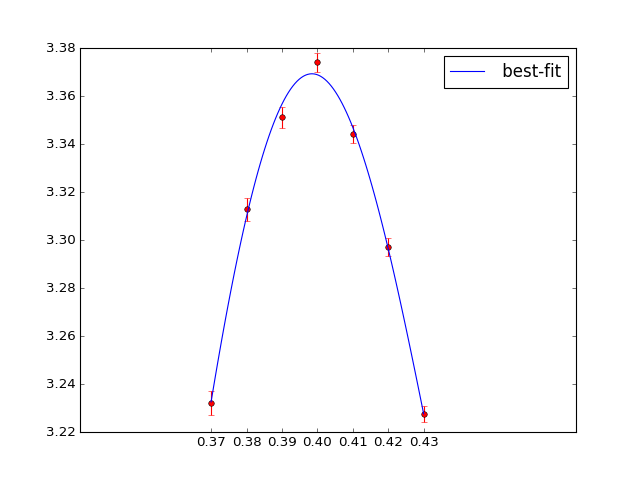

In [5]:
if __name__ == '__main__':
    param=('1','0.4','1','1','1','0')

    func,dict1=f_choose_fit(ft=6,param=param,verbose=True) # choosing fit function for evaulation

    result=f_fit(func,xdata,ydata,yerr,param,dict1)
    print result.fit_report()
    # report_fit(result.params,show_correl=False)

    plot_dict={'title':'','xlabel':'',
                   'ylabel':'','curve_label': ' best-fit'}
    f_plot(func,xdata,ydata,yerr,result,**plot_dict)
    plt.xticks(xdata)


## Add a combined fit. for sus1 and sus2
